In [ ]:
# export
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from kornia.augmentation import RandomHorizontalFlip, RandomCrop
from kornia.geometry.transform import resize
from fastcore.all import *

from deep_t2i.data_anime_heads import Datasets as AnimeHeadsDatasets, DataLoaders as AnimeHeadsDataLoaders
from deep_t2i.data_birds import Datasets as BirdsDatasets, DataLoaders as BirdsDataLoaders
from deep_t2i.model import RnnEncoder, CnnEncoder, get_pretrained_DAMSM, Anime_G, Anime_D, Birds_G, Birds_D
from deep_t2i.trainer_DAMSM import compute_sent_loss, compute_word_loss
from deep_t2i.torch_utils import *

In [ ]:
# export
import os
if os.getenv('COLAB_TPU_ADDR'):
    import torch_xla
    import torch_xla.core.xla_model as xm

In [ ]:
# default_exp trainer_GAN

In [ ]:
animeheads_data_dir = Path('../data/tiny_data/anime_heads')
birds_data_dir = Path('../data/tiny_data/birds')

# Trainer
>

In [ ]:
# exporti
bce_loss = nn.BCEWithLogitsLoss()
random_hflip = RandomHorizontalFlip().requires_grad_(False).eval()
random_crop = RandomCrop((256, 256)).requires_grad_(False).eval()

In [ ]:
# exporti
def compute_gradient_penalty(d, true_imgs, fake_imgs, sent_emb):
    bs = true_imgs[0].shape[0]
    device = true_imgs[0].device
    
    alpha = torch.rand(bs, 1, 1, 1, device=device)
    interpolates = [(alpha * true_img.detach() + ((1 - alpha) * fake_img.detach())).requires_grad_(True) for true_img, fake_img in zip(true_imgs, fake_imgs)]
    uncond_logit, cond_logit = d(interpolates, sent_emb) # (bs, 1), (bs, 1)

    uncond_grads = autograd.grad(
        outputs=uncond_logit,
        inputs=interpolates,
        grad_outputs=torch.ones_like(uncond_logit),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )
    uncond_gps = []
    for uncond_grad in uncond_grads: 
        uncond_grad = uncond_grad.contiguous().view(uncond_grad.size(0), -1)
        uncond_gp = ((uncond_grad.norm(2, dim=1) - 1) ** 2).mean()
        uncond_gps.append(uncond_gp)
    uncond_gp = torch.stack(uncond_gps).mean()
    
    cond_grads = autograd.grad(
        outputs=cond_logit,
        inputs=interpolates,
        grad_outputs=torch.ones_like(cond_logit),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )
    cond_gps = []
    for cond_grad in cond_grads: 
        cond_grad = cond_grad.contiguous().view(cond_grad.size(0), -1)
        cond_gp = ((cond_grad.norm(2, dim=1) - 1) ** 2).mean()
        cond_gps.append(cond_gp)
    cond_gp = torch.stack(cond_gps).mean()
    
    return uncond_gp, cond_gp

In [ ]:
d = Anime_D(24)
true_imgs = [torch.randn(2, 3, 64, 64), torch.randn(2, 3, 32, 32), torch.randn(2, 3, 16, 16), torch.randn(2, 3, 8, 8), torch.randn(2, 3, 4, 4)]
fake_imgs = [torch.randn(2, 3, 64, 64), torch.randn(2, 3, 32, 32), torch.randn(2, 3, 16, 16), torch.randn(2, 3, 8, 8), torch.randn(2, 3, 4, 4)]
sent_emb = torch.randn(2, 24)

uncond_gp, cond_gp = compute_gradient_penalty(d, true_imgs, fake_imgs, sent_emb)
test_eq(uncond_gp.shape, ())
test_eq(cond_gp.shape, ())

In [ ]:
# exporti
def compute_d_loss(d, fake_imgs, true_imgs, sent_emb, gp_lambda=None):
    fake_imgs = detach(fake_imgs)
    bs = sent_emb.shape[0]
    device = sent_emb.device
    ones = torch.ones((bs, 1), device=device)
    zeros = torch.zeros((bs, 1), device=device)
    false_sent_emb = torch.cat([sent_emb[bs//2:], sent_emb[:bs//2]])
 
    true_sent_code = d.get_sent_code(true_imgs)
    fake_sent_code = d.get_sent_code(fake_imgs)

    uncond_true_logit = d.uncond_cls(true_sent_code) # (bs, 1)
    uncond_fake_logit = d.uncond_cls(fake_sent_code)
    cond_tt_logit = d.cond_cls(true_sent_code, sent_emb)
    cond_tf_logit = d.cond_cls(true_sent_code, false_sent_emb)
    cond_ft_logit = d.cond_cls(fake_sent_code, sent_emb)
    cond_ff_logit = d.cond_cls(fake_sent_code, false_sent_emb)

    uncond_true_loss = bce_loss(uncond_true_logit, ones)
    uncond_fake_loss = bce_loss(uncond_fake_logit, zeros)
    cond_tt_loss = bce_loss(cond_tt_logit, ones)
    cond_tf_loss = bce_loss(cond_tf_logit, zeros)
    cond_ft_loss = bce_loss(cond_ft_logit, zeros)
    cond_ff_loss = bce_loss(cond_ff_logit, zeros)
    
#     loss = (uncond_true_loss+cond_tt_loss)/2. + (uncond_fake_loss+cond_ft_loss+cond_tf_loss)/3.
    loss = (uncond_true_loss+uncond_fake_loss) + (cond_tt_loss+(cond_tf_loss+cond_ft_loss+cond_ff_loss)/3)
    
    if gp_lambda:
        uncond_gp, cond_gp = compute_gradient_penalty(d, true_imgs, fake_imgs, sent_emb)
        uncond_gp_loss = uncond_gp*gp_lambda
        cond_gp_loss = cond_gp*gp_lambda
        loss += uncond_gp_loss+cond_gp_loss
    return loss

In [ ]:
d = Anime_D(24)
true_imgs = [torch.randn(2, 3, 64, 64), torch.randn(2, 3, 32, 32), torch.randn(2, 3, 16, 16), torch.randn(2, 3, 8, 8), torch.randn(2, 3, 4, 4)]
fake_imgs = [torch.randn(2, 3, 64, 64), torch.randn(2, 3, 32, 32), torch.randn(2, 3, 16, 16), torch.randn(2, 3, 8, 8), torch.randn(2, 3, 4, 4)]
sent_emb = torch.randn(2, 24)
loss = compute_d_loss(d, true_imgs, fake_imgs, sent_emb, gp_lambda=5)
test_eq(loss.shape, ())

In [ ]:
# exporti
def compute_g_loss(
    d_net, 
    fake_imgs, 
    sent_emb,
    cnn_code,
    word_features,
    word_emb, 
    cap_len,
    gamma1=4.0, gamma2=5.0, gamma3=10.0, smooth_lambda=2.0,
):
    bs = fake_imgs[0].shape[0]
    device = fake_imgs[0].device
    ones = torch.ones((bs, 1), device=device)
    zeros = torch.zeros((bs, 1), device=device)
    
    # loss from discriminator
    uncond_logit, cond_logit = d_net(fake_imgs, sent_emb)
    d_loss = bce_loss(uncond_logit, ones) + bce_loss(cond_logit, ones)
    
    # loss from DAMSM
    s_loss0, s_loss1 = compute_sent_loss(cnn_code, sent_emb, gamma3=gamma3)
    w_loss0, w_loss1, attn_maps = compute_word_loss(word_features, word_emb, cap_len, gamma1=gamma1, gamma2=gamma2, gamma3=gamma3)
    damsm_loss = (w_loss0+w_loss1)*smooth_lambda + (s_loss0+s_loss1)*smooth_lambda
    
    return d_loss + damsm_loss

In [ ]:
d_net = Anime_D(24)
fake_imgs = [torch.randn(2, 3, 64, 64), torch.randn(2, 3, 32, 32), torch.randn(2, 3, 16, 16), torch.randn(2, 3, 8, 8), torch.randn(2, 3, 4, 4)]
sent_emb = torch.randn(2, 24)
cnn_code = torch.randn(2, 24)
word_features = torch.randn(2, 24, 17, 17)
word_emb = torch.randn(2, 20, 24)
cap_len = torch.tensor([4, 6])
loss = compute_g_loss(d_net, fake_imgs, sent_emb, cnn_code, word_features, word_emb, cap_len)
test_eq(loss.shape, ())

In [ ]:
# exporti
@torch.no_grad()
def update_average(tgt, src, decay):
    """
    update the model_target using exponential moving averages
    :param tgt: target model
    :param src: source model
    :param decay: value of decay 
    :return: None (updates the target model)
    """
    src_dict = src.state_dict()
    tgt_dict = tgt.state_dict()
    param_names = [name for name, param in src.named_parameters()]
    for key in src_dict:
        ## Only use ema in parameters, others are just copy
        if key in param_names:
            tgt_dict[key].data.copy_(tgt_dict[key].data * decay + src_dict[key].data * (1 - decay))
        else:
            tgt_dict[key].data.copy_(src_dict[key].data)

In [ ]:
src = nn.Sequential(nn.Linear(2, 2, bias=False), nn.BatchNorm1d(2))
tgt = nn.Sequential(nn.Linear(2, 2, bias=False), nn.BatchNorm1d(2))

update_average(tgt, src, decay=0)
test_eq(is_models_equal(tgt, src), True)

## AnimeHeadsTrainer

In [ ]:
# export
class AnimeHeadsTrainer():
    def __init__(
        self, 
        data_dir, 
        bs, 
        data_pct=1, 
        g_lr=1e-3, 
        d_lr=1e-3, 
        device='cpu',
        pretrained_damsm_path: Path=None,
        smooth_lambda = 2.0,
        noise_sz=100, 
    ):
        super().__init__()
        self.smooth_lambda = smooth_lambda
        self.noise_sz = noise_sz
        
        self.device = torch.device(device)
        self.normalizer = Normalizer(device=self.device)
        
        dsets = AnimeHeadsDatasets(data_dir, pct=data_pct, valid_pct=0)
        self.dls = AnimeHeadsDataLoaders(dsets, bs)
        
        if pretrained_damsm_path is not None:
            self.rnn_encoder, self.cnn_encoder, self.vocab_sz, self.emb_sz, self.pad_id, self.rnn_layers, self.rnn_drop_p, self.gamma1, self.gamma2, self.gamma3 = get_pretrained_DAMSM(pretrained_damsm_path, device=self.device)
            self.rnn_encoder = self.rnn_encoder.requires_grad_(False).eval()
            self.cnn_encoder = self.cnn_encoder.requires_grad_(False).eval()
            assert dsets.train.tokenizer.vocab_sz==self.vocab_sz and dsets.train.tokenizer.pad_id==self.pad_id
        else:
            self.vocab_sz = dsets.train.tokenizer.vocab_sz
            self.emb_sz = 24
            self.pad_id = dsets.train.tokenizer.pad_id
            self.rnn_layers = 2 
            self.rnn_drop_p = 0.5
            self.gamma1 = 4.0
            self.gamma2 = 5.0
            self.gamma3 = 10.0
            self.rnn_encoder = RnnEncoder(self.vocab_sz, self.emb_sz, self.pad_id, n_layers=self.rnn_layers, drop_p=self.rnn_drop_p).requires_grad_(False).eval().to(device)
            self.cnn_encoder = CnnEncoder(self.emb_sz).requires_grad_(False).eval().to(device)
            
        self.g_net = Anime_G(self.emb_sz, self.noise_sz).to(self.device)
        self.g_shadow = Anime_G(self.emb_sz, self.noise_sz).to(self.device)
        self.g_shadow.load_state_dict(self.g_net.state_dict())
        self.d_net = Anime_D(self.emb_sz).to(self.device)
        
        self.optim_g = optim.Adam(self.g_net.parameters(), lr=g_lr, betas=(0, 0.999))
        self.optim_d = optim.Adam(self.d_net.parameters(), lr=d_lr, betas=(0, 0.999))
    def after_batch_tfm(self, cap, cap_len, img):
        "cap: (bs, 2), cap_len: (bs,), img: (bs, 64, 64, 3)"
        img64 = img.permute(0, 3, 1, 2).float() # (bs, 3, 64, 64)
        img64 = random_hflip(img64)
        img4 = resize(img64, size=(4, 4))
        img8 = resize(img64, size=(8, 8))
        img16 = resize(img64, size=(16, 16))
        img32 = resize(img64, size=(32, 32))
        
        img4 = self.normalizer.encode(img4) # (bs, 3, 4, 4)
        img8 = self.normalizer.encode(img8) # (bs, 3, 8, 8)
        img16 = self.normalizer.encode(img16) # (bs, 3, 16, 16)
        img32 = self.normalizer.encode(img32) # (bs, 3, 32, 32)
        img64 = self.normalizer.encode(img64) # (bs, 3, 64, 64)
        return cap, cap_len, (img64, img32, img16, img8, img4)   

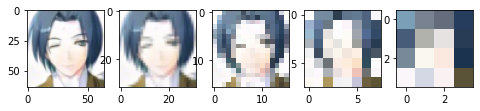

In [ ]:
# Test for after_batch_tfm
trainer = AnimeHeadsTrainer(animeheads_data_dir, 1)
imgs = []

cap, cap_len, img = iter(trainer.dls.train).next()
cap, cap_len, img = to_device([cap, cap_len, img], trainer.device)
cap, cap_len, (img64, img32, img16, img8, img4) = trainer.after_batch_tfm(cap, cap_len, img)
imgs = [img64[0],img32[0], img16[0], img8[0], img4[0]]
test_eq(cap.shape, (1, 2))
test_eq(img4.shape, (1, 3, 4, 4))
test_eq(img8.shape, (1, 3, 8, 8))
test_eq(img16.shape, (1, 3, 16, 16))
test_eq(img32.shape, (1, 3, 32, 32))
test_eq(img64.shape, (1, 3, 64, 64))

_ , axes = plt.subplots(1, 5, figsize=(8, 8))
for i in range(5):
    img = trainer.normalizer.decode(imgs[i][None]).permute(0, 2, 3, 1)[0]
    axes[i].imshow(img.cpu())

## BirdsTrainer

In [ ]:
# export
class BirdsTrainer():
    def __init__(
        self, 
        data_dir, 
        bs, 
        data_pct=1, 
        g_lr=1e-3, 
        d_lr=1e-3,  
        device='cpu',
        pretrained_damsm_path: Path=None,
        smooth_lambda=2.0,
        noise_sz=100,
    ):
        super().__init__()
        self.smooth_lambda = smooth_lambda
        self.noise_sz = noise_sz
        
        self.device = torch.device(device)
        self.normalizer = Normalizer(device=self.device)
        
        dsets = BirdsDatasets(data_dir, pct=data_pct)
        self.dls = BirdsDataLoaders(dsets, bs)
        
        if pretrained_damsm_path is not None:
            self.rnn_encoder, self.cnn_encoder, self.vocab_sz, self.emb_sz, self.pad_id, self.rnn_layers, self.rnn_drop_p, self.gamma1, self.gamma2, self.gamma3 = get_pretrained_DAMSM(pretrained_damsm_path, device=self.device)
            self.rnn_encoder = self.rnn_encoder.requires_grad_(False).eval()
            self.cnn_encoder = self.cnn_encoder.requires_grad_(False).eval()
            assert dsets.train.tokenizer.vocab_sz==self.vocab_sz and dsets.train.tokenizer.pad_id==self.pad_id
        else:
            self.vocab_sz = dsets.train.tokenizer.vocab_sz
            self.emb_sz = 24
            self.pad_id = dsets.train.tokenizer.pad_id
            self.rnn_layers = 2
            self.rnn_drop_p = 0.5
            self.gamma1 = 4.0
            self.gamma2 = 5.0
            self.gamma3 = 10.0
            self.rnn_encoder = RnnEncoder(self.vocab_sz, self.emb_sz, self.pad_id, n_layers=self.rnn_layers, drop_p=self.rnn_drop_p).requires_grad_(False).eval().to(device)
            self.cnn_encoder = CnnEncoder(self.emb_sz).requires_grad_(False).eval().to(device)
        
        self.g_net = Birds_G(self.emb_sz, self.noise_sz).to(self.device)
        self.g_shadow = Birds_G(self.emb_sz, self.noise_sz).to(self.device)
        self.g_shadow.load_state_dict(self.g_net.state_dict())
        self.d_net = Birds_D(self.emb_sz).to(self.device)
        
        self.optim_g = optim.Adam(self.g_net.parameters(), lr=g_lr, betas=(0, 0.999))
        self.optim_d = optim.Adam(self.d_net.parameters(), lr=d_lr, betas=(0, 0.999))
    def after_batch_tfm(self, cap, cap_len, img):
        " cap: (bs, 25), img: (bs, 256, 256, 3) "
        img256 = img.permute(0, 3, 1, 2).float() # (bs, 3, 256, 256)
        img256 = resize(img256, size=(int(256 * 76 / 64), int(256 * 76 / 64))) # (bs, 3, 304, 304)
        img256 = random_crop(img256) # (bs, 3, 256, 256)
        img256 = random_hflip(img256)

        img4 = resize(img256, size=(4, 4))
        img8 = resize(img256, size=(8, 8))
        img16 = resize(img256, size=(16, 16))
        img32 = resize(img256, size=(32, 32))
        img64 = resize(img256, size=(64, 64))
        img128 = resize(img256, size=(128, 128))
        
        img4 = self.normalizer.encode(img4) # (bs, 3, 4, 4)
        img8 = self.normalizer.encode(img8) # (bs, 3, 8, 8)
        img16 = self.normalizer.encode(img16) # (bs, 3, 16, 16)
        img32 = self.normalizer.encode(img32) # (bs, 3, 32, 32)
        img64 = self.normalizer.encode(img64) # (bs, 3, 64, 64)
        img128 = self.normalizer.encode(img128) # (bs, 3, 128, 128)
        img256 = self.normalizer.encode(img256) # (bs, 3, 256, 256)
        return cap, cap_len, (img256, img128, img64, img32, img16, img8, img4)

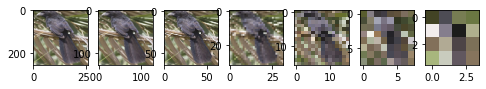

In [ ]:
# Test for after_batch_tfm
trainer = BirdsTrainer(birds_data_dir, 1)
imgs = []

cap, cap_len, img = iter(trainer.dls.train).next()
cap, cap_len, img = to_device([cap, cap_len, img], trainer.device)
cap, cap_len, (img256, img128, img64, img32, img16, img8, img4) = trainer.after_batch_tfm(cap, cap_len, img)
imgs = [img256[0], img128[0], img64[0], img32[0], img16[0], img8[0], img4[0]]
test_eq(cap.shape, (1, 25))
test_eq(img4.shape, (1, 3, 4, 4))
test_eq(img8.shape, (1, 3, 8, 8))
test_eq(img16.shape, (1, 3, 16, 16))
test_eq(img32.shape, (1, 3, 32, 32))
test_eq(img64.shape, (1, 3, 64, 64))
test_eq(img128.shape, (1, 3, 128, 128))
test_eq(img256.shape, (1, 3, 256, 256))

_ , axes = plt.subplots(1, 7, figsize=(8, 8))
for i in range(7):
    img = trainer.normalizer.decode(imgs[i][None]).permute(0, 2, 3, 1)[0]
    axes[i].imshow(img.cpu())

## Patch

In [ ]:
# exporti
@patch
def set_device(self: [AnimeHeadsTrainer, BirdsTrainer], device='cpu'):
    self.device = torch.device(device)
    self.normalizer.set_device(self.device)
    self.c_encoder.to(self.device)
    self.g_net.to(self.device)
    self.g_shadow.to(self.device)
    self.d_net.to(self.device)
@patch
def set_model_mode(self: [AnimeHeadsTrainer, BirdsTrainer], mode):
    if mode=='D':
#         self.g_net.eval()
        self.g_net.requires_grad_(False)
        self.d_net.train()
        self.d_net.requires_grad_(True)
    elif mode=='G':
        self.g_net.train()
        self.g_net.requires_grad_(True)
#         self.d_net.eval()
        self.d_net.requires_grad_(False)
    else:
        raise Exception('Oops!!')
@patch
def save_checkpoint(self: [AnimeHeadsTrainer, BirdsTrainer], path):
    state = {
        'g_net': self.g_net.state_dict(), 
        'g_shadow': self.g_shadow.state_dict(),
        'd_net': self.d_net.state_dict(),
        'optim_g': self.optim_g.state_dict(),
        'optim_d': self.optim_d.state_dict(),
    }
    torch.save(state, path)
@patch
def load_checkpoint(self: [AnimeHeadsTrainer, BirdsTrainer], path):
    state = torch.load(path, map_location=self.device)
    self.g_net.load_state_dict(state['g_net'])
    if 'g_shadow' in state:
        self.g_shadow.load_state_dict(state['g_shadow'])
    else:
        self.g_shadow.load_state_dict(state['g_net'])
    self.d_net.load_state_dict(state['d_net'])
    self.optim_g.load_state_dict(state['optim_g'])
    self.optim_d.load_state_dict(state['optim_d'])
@patch
def export(self: [AnimeHeadsTrainer, BirdsTrainer], path, is_ema=True):
#     assert n_samples <= self.dls.train.batch_size
#     cap, cap_len, img = iter(self.dls.train).next()
#     cap = cap[:n_samples]
#     cap_len = cap_len[:n_samples]
    g_net = self.g_shadow if is_ema else self.g_net
    state = {
        'vocab_sz': self.vocab_sz,
        'emb_sz': self.emb_sz,
        'pad_id': self.pad_id,
        'rnn_layers': self.rnn_layers,
        'rnn_drop_p': self.rnn_drop_p,
        'noise_sz': self.noise_sz,
        'rnn_encoder': self.rnn_encoder.state_dict(),
        'g_net': g_net.state_dict(),
#         'samples': (cap, cap_len),
    }
    torch.save(state, path)
@patch
def generate_imgs(self: [AnimeHeadsTrainer, BirdsTrainer], cap, cap_len, img, noise, is_ema=False):
    g_net = self.g_shadow if is_ema else self.g_net
    
    cap, cap_len, true_imgs = self.after_batch_tfm(cap, cap_len, img)
    bs, max_seq_len = cap.shape
    device = cap.device
    src_mask = get_src_mask(cap_len, max_seq_len, device)
    sent_emb, word_emb = detach(self.rnn_encoder(cap, cap_len))
    fake_imgs = g_net(sent_emb, noise, word_emb, src_mask)
    fake_imgs = list(reversed(fake_imgs))
    return cap, cap_len, true_imgs, sent_emb, word_emb, fake_imgs
    # true_imgs and fake_imgs: large to small
@patch
@torch.no_grad()
def check_d(self: [AnimeHeadsTrainer, BirdsTrainer], is_ema=False):
    cap, cap_len, img = iter(self.dls.train).next()
    cap, cap_len, img = to_device([cap, cap_len, img], device=self.device)
    noise = noise_gen.sample((cap.shape[0], self.noise_sz)).to(self.device)
    cap, cap_len, true_imgs, sent_emb, word_emb, fake_imgs = self.generate_imgs(cap, cap_len, img, noise, is_ema=is_ema)

    t_logits = self.d_net(true_imgs, sent_emb)
    f_logits = self.d_net(fake_imgs, sent_emb)

    ts = [torch.sigmoid(logit) for logit in t_logits] # t_uncond_s, t_cond_s
    fs = [torch.sigmoid(logit) for logit in f_logits] # f_uncond_s, f_cond_s
    
    return list(zip(ts, fs))  

In [ ]:
# exporti
@patch
def decode(self: [AnimeHeadsTrainer, BirdsTrainer], tag, true_img, *fake_imgs):
    caps = [self.dls.dsets.train.tokenizer.decode(t) for t in tag]
    true_imgs = self.normalizer.decode(true_img).permute(0, 2, 3, 1).cpu()
    fake_imgs = [self.normalizer.decode(fake_img).permute(0, 2, 3, 1).cpu() for fake_img in fake_imgs]
    return caps, true_imgs, fake_imgs
@patch
@torch.no_grad()
def fig_for_show(self: [AnimeHeadsTrainer, BirdsTrainer], is_valid=False, is_ema=False):
    dl = self.dls.valid if is_valid else self.dls.train
    cap, cap_len, img = iter(dl).next()
    cap, cap_len, img = to_device([cap, cap_len, img], device=self.device)
    noise = noise_gen.sample((cap.shape[0], self.noise_sz)).to(self.device)
    cap, cap_len, true_imgs, sent_emb, word_emb, fake_imgs = self.generate_imgs(cap, cap_len, img, noise, is_ema=is_ema)
    caps, true_img, fake_imgs = self.decode(cap, true_imgs[0], *fake_imgs) # List of cap, (bs,), List of (bs,)
    
    ncols = len(fake_imgs)+1
    nrows = 4
    figsize = (ncols*4, nrows*4)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = ax.flatten()
    for i in range(nrows):
        ax[i][0].imshow(true_img[i])
        for j in range(len(fake_imgs)):
            ax[i][j+1].imshow(fake_imgs[j][i])
        ax[i][0].text(0, -1.5, caps[i])
    return fig
@patch
def show(self: [AnimeHeadsTrainer, BirdsTrainer], is_valid=False, is_ema=False):
    fig = self.fig_for_show(is_valid, is_ema)
    display(fig)
    plt.close()
@patch
def save_jpg(self: [AnimeHeadsTrainer, BirdsTrainer], path, is_valid=False, is_ema=False):
    fig = self.fig_for_show(is_valid, is_ema)
    fig.savefig(path)
    plt.close()

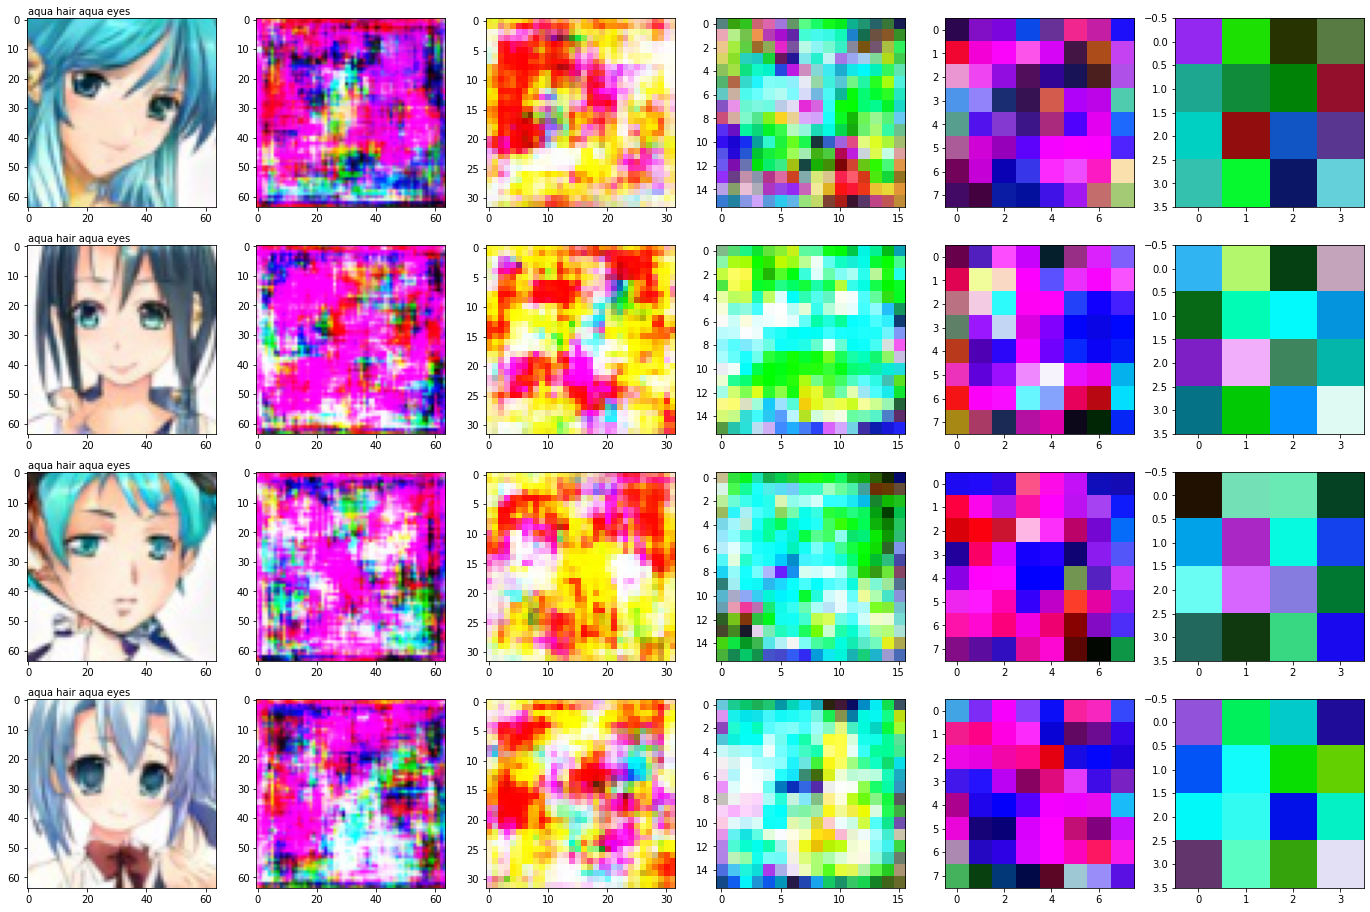

In [ ]:
trainer = AnimeHeadsTrainer(animeheads_data_dir, 4)
trainer.show()

In [ ]:
# exporti
@patch
def train(
    self: [AnimeHeadsTrainer, BirdsTrainer],
    n_step, # 1 step = train discriminator 1 and train generator 1
    step_per_epoch=500, # print loss each step_per_epoch
    savejpg_every=None, 
    jpg_path:str=None,
    is_jpg_ema=False,
    saveck_every=None, 
    ck_path:str=None, 
    n_gradient_acc=1,
    gp_lambda=None, 
    ema_decay=0.999, 
):                 
    assert n_step%step_per_epoch==0, f'n_step: {n_step} % step_per_epoch: {step_per_epoch} should be 0'
    g_losses = []
    d_losses = []
    total_start_t = time.time()
    log_start_t = time.time()
    dl = InfiniteDl(self.dls.train)

    pb = tqdm(range(1, n_step+1))
    for step in pb:        
        # Train Discriminator
        self.set_model_mode('D')
        self.optim_d.zero_grad()
        d_ls = 0
        caches = list(range(n_gradient_acc))
        for i in range(n_gradient_acc):
            cap, cap_len, img = to_device(dl.next(), device=self.device)            
            noise = noise_gen.sample((cap.shape[0], self.noise_sz)).to(self.device)
            caches[i] = (cap.cpu(), cap_len.cpu(), img.cpu(), noise.cpu())
            cap, cap_len, true_imgs, sent_emb, word_emb, fake_imgs = self.generate_imgs(cap, cap_len, img, noise, is_ema=False)
            d_loss = compute_d_loss(self.d_net, fake_imgs, true_imgs, sent_emb, gp_lambda=gp_lambda) / n_gradient_acc
            d_ls += d_loss
            d_loss.backward()
        d_losses.append(d_ls.detach().cpu())
        self.optim_d.step() if self.device.type!='xla' else xm.optimizer_step(self.optim_d, barrier=True)

        # Train Generator
        self.set_model_mode('G')
        self.optim_g.zero_grad()
        g_ls = 0
        for i in range(n_gradient_acc):
            cap, cap_len, img, noise = to_device(caches[i], device=self.device)
            cap, cap_len, true_imgs, sent_emb, word_emb, fake_imgs = self.generate_imgs(cap, cap_len, img, noise, is_ema=False)
            word_features, cnn_code = self.cnn_encoder(fake_imgs[0])
            g_loss = compute_g_loss(self.d_net, fake_imgs, sent_emb, cnn_code, word_features, word_emb, cap_len, gamma1=self.gamma1, gamma2=self.gamma2, gamma3=self.gamma3, smooth_lambda=self.smooth_lambda) / n_gradient_acc
            g_ls += g_loss
            g_loss.backward()
        g_losses.append(g_ls.detach().cpu())
        self.optim_g.step() if self.device.type!='xla' else xm.optimizer_step(self.optim_g, barrier=True)
        update_average(self.g_shadow, self.g_net, ema_decay)

        pb.set_postfix(g_loss=g_ls.detach().cpu().numpy(), d_loss=d_ls.detach().cpu().numpy())

        # show or save something
        if savejpg_every and step%savejpg_every == 0:
            self.save_jpg(path=jpg_path+f'-{step//savejpg_every}.jpg', is_ema=is_jpg_ema)
        if saveck_every and step%saveck_every == 0:
            self.save_checkpoint(path=ck_path+f'-{step//saveck_every}.pt')
        if step%step_per_epoch == 0:
            duration = time.time() - log_start_t
            msg = f'{step//step_per_epoch}, time: {duration:.1f}s, g_loss: {torch.tensor(g_losses).mean():.4f}, d_loss: {torch.tensor(d_losses).mean():.4f}'
            tqdm.write(msg)
            g_losses = []
            d_losses = []
            log_start_t = time.time() 
    pb.close()
    tqdm.write(f'total_time: {(time.time()-total_start_t)/60:.1f}min')

In [ ]:
# trainer = AnimeHeadsTrainer(animeheads_data_dir, 4, device='cuda')
# trainer.train(50, step_per_epoch=10, n_gradient_acc=2)

1, time: 7.2s, g_loss: 14.9017, d_loss: 7.0551
2, time: 7.6s, g_loss: 14.6520, d_loss: 2.8876
3, time: 7.5s, g_loss: 15.5638, d_loss: 3.2864
4, time: 6.7s, g_loss: 14.7423, d_loss: 2.7229
5, time: 4.0s, g_loss: 22.1710, d_loss: 3.4763

total_time: 0.6min


In [ ]:
# trainer = BirdsTrainer(birds_data_dir, 4, device='cuda')
# trainer.train(4, step_per_epoch=2, n_gradient_acc=2)

1, time: 3.7s, g_loss: 16.9234, d_loss: 34.8216
2, time: 1.6s, g_loss: 16.4146, d_loss: 3.6390

total_time: 0.1min


## Export -

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_utils.ipynb.
Converted 02a_data_anime_heads.ipynb.
Converted 02b_data_birds.ipynb.
Converted 03a_model.ipynb.
Converted 04a_trainer_DAMSM.ipynb.
Converted 04b_trainer_GAN.ipynb.
Converted 05a_inference_anime_heads.ipynb.
Converted 05b_inference_birds.ipynb.
Converted index.ipynb.
